# Tree Algorithms and Decision Tree Classifier Lab

## Overview

**Team 5, Arsenii Stratiuk, Viktor Syrotiuk**

This repository contains a student lab project focused on implementing and analyzing fundamental tree algorithms and a Decision Tree classifier. The project is divided into two main tasks:

1. **Task 1: Graph Algorithm Analysis**  
   - Implementation and comparison of **Kruskal's** and **Prim's** algorithms for Minimum Spanning Trees (MST).  
   - Analysis of **Bellman-Ford** and **Floyd-Warshall** algorithms for shortest path detection in graphs.  
   - Time complexity measurements and performance plots for varying graph sizes.

2. **Task 2: Decision Tree Classifier**  
   - A custom Decision Tree classifier built from scratch using Gini impurity.  
   - Validation on the Iris dataset, with comparisons to scikit-learn's implementation.  
   - Visualization of tree structures and accuracy evaluation.

In [1]:
# !pip install networkx
# !pip install matplotlib
# !pip install tqdm
# !pip install pandas
# !pip install numpy
# !pip install graphviz
# !pip install scikit-learn

In [2]:
import time
import random
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations, groupby

from networkx.algorithms import tree
from networkx.algorithms import bellman_ford_predecessor_and_distance
from networkx.algorithms import floyd_warshall_predecessor_and_distance

import numpy.typing as npt

# Task 1. Algorithm's analysis

## Generating graph

In [3]:

# You can use this function to generate a random graph with 'num_of_nodes' nodes
# and 'completeness' probability of an edge between any two nodes
# If 'directed' is True, the graph will be directed
# If 'draw' is True, the graph will be drawn
def gnp_random_connected_graph(num_of_nodes: int,
                               completeness: int,
                               directed: bool = False,
                               draw: bool = False):
    """
    Generates a random graph, similarly to an Erdős-Rényi 
    graph, but enforcing that the resulting graph is conneted (in case of undirected graphs)
    """

    
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()
    edges = combinations(range(num_of_nodes), 2)
    G.add_nodes_from(range(num_of_nodes))
    
    for _, node_edges in groupby(edges, key = lambda x: x[0]):
        node_edges = list(node_edges)
        random_edge = random.choice(node_edges)
        if random.random() < 0.5:
            random_edge = random_edge[::-1]
        G.add_edge(*random_edge)
        for e in node_edges:
            if random.random() < completeness:
                G.add_edge(*e)
                
    for (u,v,w) in G.edges(data=True):
        w['weight'] = random.randint(-5, 20)
                
    if draw: 
        plt.figure(figsize=(10,6))
        if directed:
            # draw with edge weights
            pos = nx.arf_layout(G)
            nx.draw(G,pos, node_color='lightblue', 
                    with_labels=True,
                    node_size=500, 
                    arrowsize=20, 
                    arrows=True)
            labels = nx.get_edge_attributes(G,'weight')
            nx.draw_networkx_edge_labels(G, pos,edge_labels=labels)
            
        else:
            nx.draw(G, node_color='lightblue', 
                with_labels=True, 
                node_size=500)
        
    return G

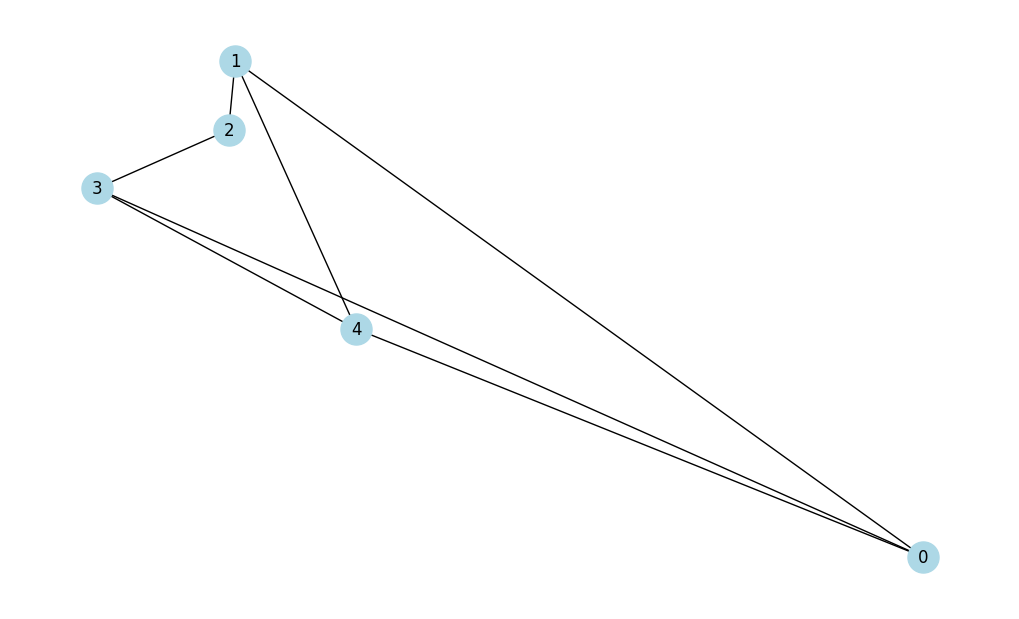

In [4]:
G = gnp_random_connected_graph(5, 0.5, False, True)

## Subtask 1.1

### Kruskal's algorithm

In [5]:
mstk = tree.minimum_spanning_tree(G, algorithm="kruskal")

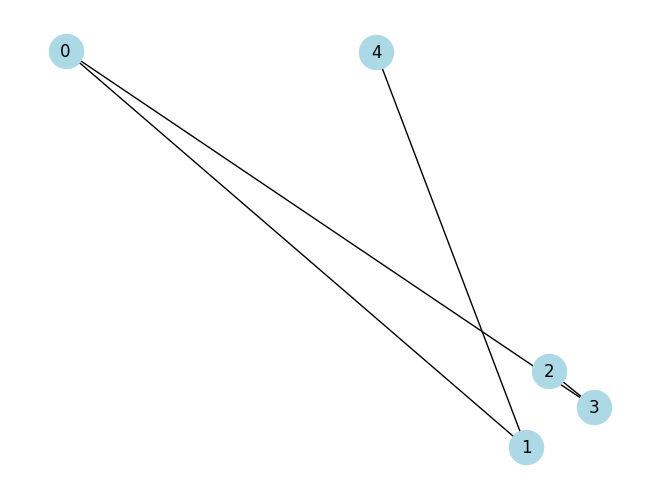

In [6]:
nx.draw(mstk, node_color='lightblue', 
        with_labels=True, 
        node_size=600)

In [7]:
print(mstk.edges(), len(mstk.edges()))
print(f'The weight of the MST is: {sum([w["weight"] for (_,_,w) in mstk.edges(data=True)])}')

[(0, 1), (0, 3), (1, 4), (2, 3)] 4
The weight of the MST is: -3


## Algorithm Implementation: Kruskal's Algorithm

The given implementation of Kruskal's algorithm follows a simple approach using a dictionary to track components and a sorted edge list. The algorithm works as follows:

- Sorts the edges in ascending order based on their weight.
- Uses a dictionary to keep track of which component each node belongs to.
- Iterates over sorted edges, adding an edge to the MST if it connects two different components.
- Merges components by updating the dictionary values.

While this approach is straightforward, updating the dictionary for merging components can be inefficient for large graphs.

### Complexity Analysis

Sorting edges is **O(Elog(E))**, since Python’s sorted() function uses Timsort.

Merging components is **O(VE)** in the worst case, as updating the dictionary is inefficient.

Overall time complexity is **O(Elog(E) + VE)**, which can be improved.

Space complexity is **O(V + E)**, since we store edge lists and component mappings.

One major improvement is using the Union-Find (Disjoint Set Union - DSU) with Path Compression. This optimizes merging components to nearly constant time, reducing the overall complexity to **O(Elog(E))**. This is likely how networkx algorithm is implemented, which should be visible in time comparisons.

In [8]:
def kruskal(G: nx.Graph) -> nx.Graph:
    """
    Implement the Kruskal's algorithm to find the Minimum Spanning Tree of a graph.
    
    Args:
        G (nx.Graph): A connected graph with weighted edges.

    Returns:
        nx.Graph: A Minimum Spanning Tree of G.
    """
    mst = nx.Graph()

    edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'])
    components = {node: i for i, node in enumerate(G.nodes)}

    for u, v, w in edges:
        if components[u] != components[v]:
            mst.add_edge(u, v, weight=w['weight'])
            linked_component = components[v]
            for node, component in components.items():
                if component == linked_component:
                    components[node] = components[u]
                    
    return mst

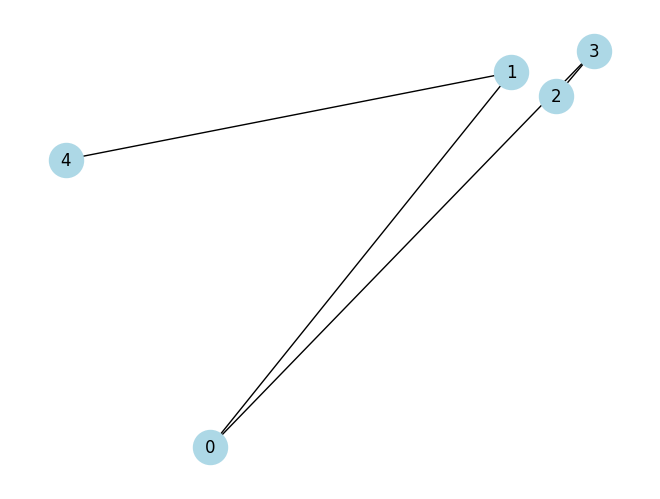

In [ ]:
# Test the manual implementation.
mst = kruskal(G)
nx.draw(mst, node_color='lightblue', 
        with_labels=True, 
        node_size=600)

In [10]:
print(mst.edges(), len(mst.edges()))
print(f'The weight of the MST is {sum([w["weight"] for _, _, w in mst.edges(data=True)])}')

[(0, 1), (0, 3), (1, 4), (3, 2)] 4
The weight of the MST is -3


### Prim's algorithm

In [11]:
mstp = tree.minimum_spanning_tree(G, algorithm="prim")

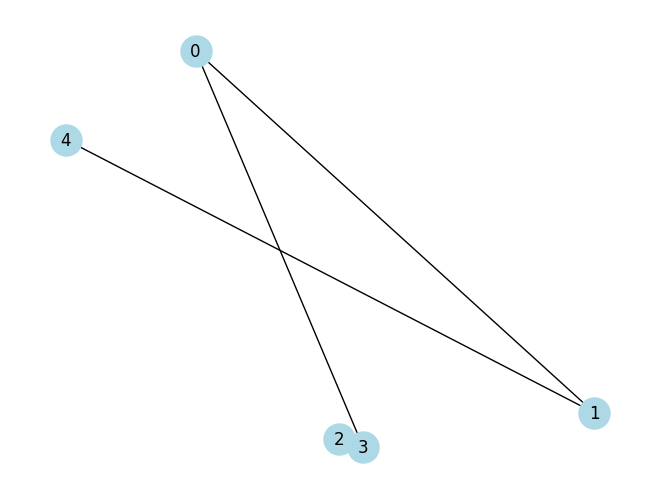

In [12]:
nx.draw(mstp, node_color='lightblue', 
        with_labels=True, 
        node_size=500)

In [13]:
print(mstp.edges(), len(mstp.edges()))
print(f'The weight of the MST is {sum([w["weight"] for _, _, w in mstp.edges(data=True)])}')

[(0, 1), (0, 3), (1, 4), (2, 3)] 4
The weight of the MST is -3


## Algorithm Implementation: Prim's Algorithm

The given implementation of Prim's algorithm follows a simple approach using a boolean list to track selected nodes and iterating over all edges to find the minimum weight edge at each step. The algorithm works as follows:  

- Initializes a list to track selected nodes, starting with the first node.  
- Iterates until all nodes are included in the MST.  
- At each step, finds the minimum weight edge that connects a selected node to an unselected node.  
- Adds the selected edge to the MST and marks the new node as selected.  

While this approach is straightforward, the selection process of the minimum edge is inefficient for large graphs, as it scans all possible edges at each step.  

### Complexity Analysis  

Finding the minimum edge requires **O(V²)** time complexity in the worst case, as it checks all edges for each selected node.  

Overall time complexity is **O(V²)**, which is suboptimal for sparse graphs.  

Space complexity is **O(V + E)**, since we store the MST graph and the selected node list.  

One major improvement is using a priority queue (min-heap) (such as Python’s heapq) to efficiently extract the minimum edge in **O(log V)** time, reducing the overall complexity to **O(E log V)**. This is likely how networkx implements Prim’s algorithm, which should be visible in time comparisons.

In [14]:
def prims_mst(graph: nx.Graph) -> nx.Graph:
    """
    Implement Prim's algorithm to find the Minimum Spanning Tree (MST)
    and return it as a graph.
    
    Args:
        graph (nx.Graph): A connected graph with weighted edges.
    
    Returns:
        nx.Graph: A Minimum Spanning Tree of the input graph.
    """
    num_nodes = len(graph.nodes)
    selected_nodes = [False] * num_nodes
    selected_nodes[0] = True 
    mst = nx.Graph()

    while False in selected_nodes:
        min_weight = float('inf')
        min_edge = None

        for u in range(num_nodes):
            if selected_nodes[u]:
                for v in range(num_nodes):
                    if not selected_nodes[v] and graph.has_edge(u, v):
                        weight = graph[u][v]['weight']
                        if weight < min_weight:
                            min_weight = weight
                            min_edge = (u, v)

        if min_edge:
            u, v = min_edge
            mst.add_edge(u, v, weight=min_weight)
            selected_nodes[v] = True

    return mst

[(0, 1), (0, 3), (1, 4), (3, 2)] 4
The weight of the MST is -3


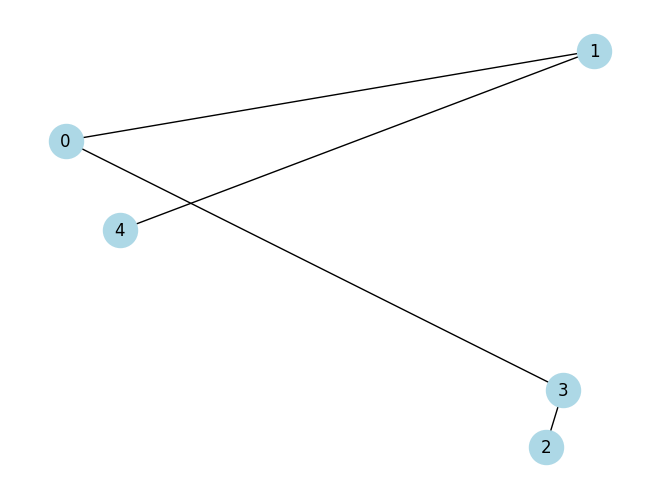

In [ ]:
# Test the Prim's algorithm implementation.
mst = prims_mst(G)
nx.draw(mst, node_color='lightblue',
        with_labels=True,
        node_size=600)
print(mst.edges(), len(mst.edges()))
print(f'The weight of the MST is {sum([w["weight"] for _, _, w in mst.edges(data=True)])}')

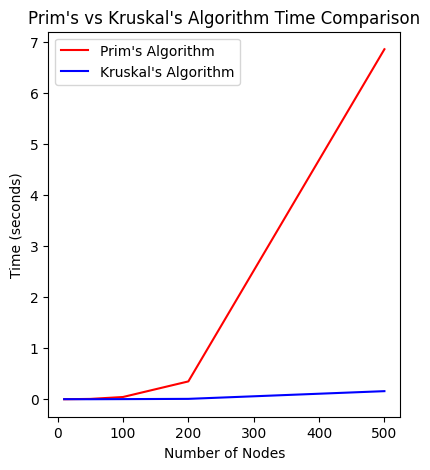

In [16]:
def calculate_time(func: callable, num_of_nodes: int, completeness: float, directed: bool = False, draw: bool = False) -> float:
    """
    Function to calculate the time taken by the given function (MST algorithm).
    :param callable func: function (either Prim's or Kruskal's algorithm)
    :param int size: size of matrix
    :return float: time of code running
    """
    graph = gnp_random_connected_graph(num_of_nodes, completeness, directed, draw)
    start_time = time.time()
    func(graph)
    return time.time() - start_time
sizes = [(10, 0.5, False), (50, 0.5, False), (100, 0.5, False), (200, 0.5, False), (500, 0.5, False)]
prim_data = []
kruskal_data = []

for size in sizes:
    prim_time = calculate_time(prims_mst, size[0], size[1], size[2])
    prim_data.append(prim_time)
    
    kruskal_time = calculate_time(kruskal, size[0], size[1], size[2])
    kruskal_data.append(kruskal_time)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot([size[0] for size in sizes], prim_data, label="Prim's Algorithm", color="red")
plt.plot([size[0] for size in sizes], kruskal_data, label="Kruskal's Algorithm", color="blue")
plt.title("Prim's vs Kruskal's Algorithm Time Comparison")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.legend()

plt.show()

## Subtask 1.2

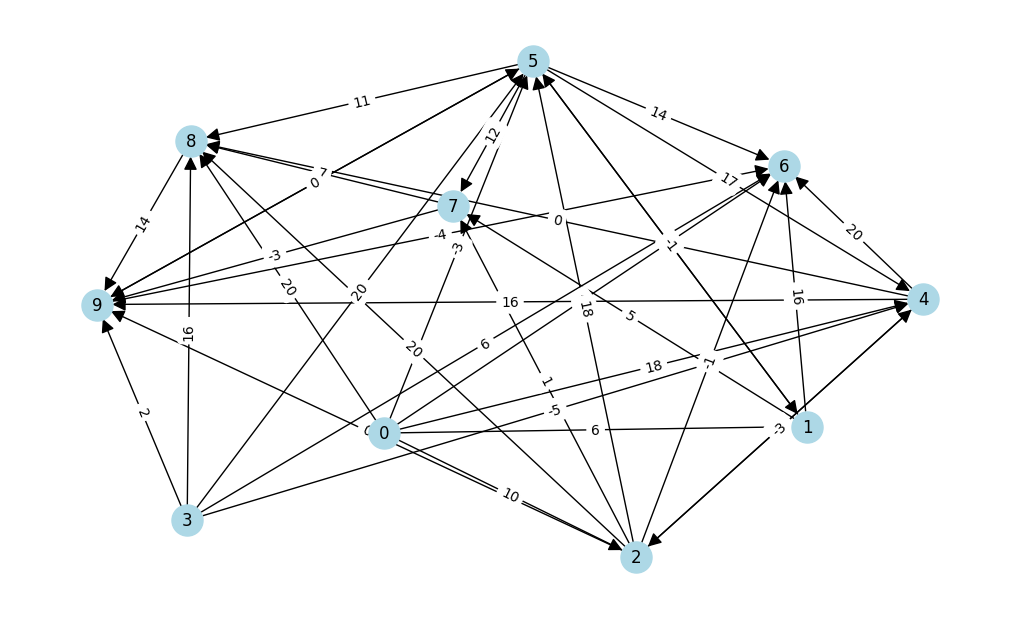

In [17]:
G = gnp_random_connected_graph(10, 0.5, True, True)

### Bellman-Ford algorithm

In [18]:
# pred is a dictionary of predecessors, dist is a dictionary of distances
try:
    pred, dist = bellman_ford_predecessor_and_distance(G, 0)
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 6: -6
Distance to 1: -4
Distance to 2: 10
Distance to 4: 14
Distance to 5: -3
Distance to 8: 8
Distance to 7: 1
Distance to 9: -2


## Algorithm Implementation: Bellman-Ford Algorithm

The given implementation of the Bellman-Ford algorithm follows a simple approach using dictionaries to store distances and predecessors. The algorithm works as follows:

- Initializes distances to all nodes as infinity, except the source node, which is set to zero.
- Iterates V - 1 times over all edges, relaxing them by updating the shortest known distance to each node.
- Performs an additional iteration to check for negative-weight cycles by verifying if any distance can still be reduced.
- Raises an exception if a negative-weight cycle is detected.

### Complexity Analysis

Relaxing all edges requires **O(VE)** time complexity in the worst case, as it iterates **V - 1** times over **E** edges.

Overall time complexity is **O(VE)**.

Space complexity is **O(V)**, since it stores distance and predecessor dictionaries.

One major feature is using early termination if no distances change in an iteration, which can significantly reduce runtime for some graphs. This is likely how `networkx` optimizes its Bellman-Ford implementation as well.

In [19]:
def bellman_ford(graph: nx.Graph, source: int) -> tuple[dict[int, int], dict[int, int]]:
    """
    Implement the Bellman-Ford algorithm to find the shortest paths from a source node to all other nodes.
    
    Args:
        graph (nx.Graph): A graph with weighted edges.
        source (int): The source node to start the search from.
    
    Returns:
        tuple[dict[int, int], dict[int, int]]: A tuple containing two dictionaries:
            - The first dictionary contains the predecessors for each node in the path.
            - The second dictionary contains the distances from the source node to each node.
    """
    num_nodes = len(graph.nodes)
    dist = {node: float('inf') for node in graph.nodes}
    pred = {node: None for node in graph.nodes}
    dist[source] = 0

    for _ in range(num_nodes - 1):
        updated = False
        for u, v in graph.edges:
            weight = graph[u][v]['weight']
            if dist[u] + weight < dist[v]:
                dist[v] = dist[u] + weight
                pred[v] = u
                updated = True
        if not updated:
            break

    for u, v in graph.edges:
        weight = graph[u][v]['weight']
        if dist[u] + weight < dist[v]:
            raise ValueError("Graph contains a negative-weight cycle")

    return pred, dist

In [ ]:
# Test the Bellman-Ford algorithm implementation.
pred, dist = bellman_ford(G, 0)
try:
    for k, v in dist.items():
        print(f"Distance to {k}:", v)
except:
    print("Negative cycle detected")

Distance to 0: 0
Distance to 1: -4
Distance to 2: 10
Distance to 3: inf
Distance to 4: 14
Distance to 5: -3
Distance to 6: -6
Distance to 7: 1
Distance to 8: 8
Distance to 9: -2


### Floyd-Warshall algorithm

In [ ]:
# pred is a dictionary of predecessors, dist is a dictionary of distances dictionaries
try:
    pred, dist = floyd_warshall_predecessor_and_distance(G) 
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except ValueError:
    print("Negative cycle detected")

Distances with 0 source: {0: 0, 6: -6, 1: -4, 2: 10, 4: 14, 5: -3, 8: 8, 3: inf, 7: 1, 9: -2}
Distances with 1 source: {1: 0, 5: 2, 6: -2, 7: 5, 0: inf, 2: 16, 3: inf, 4: 19, 8: 12, 9: 2}
Distances with 2 source: {2: 0, 4: 10, 5: -2, 6: -6, 7: 1, 8: 8, 9: -2, 0: inf, 1: -3, 3: inf}
Distances with 3 source: {3: 0, 4: -5, 5: -10, 6: -14, 8: -5, 9: -10, 0: inf, 1: -11, 2: -8, 7: -7}
Distances with 4 source: {4: 0, 2: -3, 6: -9, 8: 0, 9: -5, 0: inf, 1: -6, 3: inf, 5: -5, 7: -2}
Distances with 5 source: {5: 0, 1: -1, 4: 17, 6: -3, 7: 4, 8: 11, 9: 1, 0: inf, 2: 14, 3: inf}
Distances with 6 source: {6: 0, 0: inf, 1: inf, 2: inf, 3: inf, 4: inf, 5: inf, 7: inf, 8: inf, 9: inf}
Distances with 7 source: {7: 0, 9: -3, 8: 7, 0: inf, 1: -4, 2: 11, 3: inf, 4: 14, 5: -3, 6: -7}
Distances with 8 source: {8: 0, 9: 14, 0: inf, 1: 13, 2: 28, 3: inf, 4: 31, 5: 14, 6: 10, 7: 18}
Distances with 9 source: {9: 0, 5: 0, 6: -4, 0: inf, 1: -1, 2: 14, 3: inf, 4: 17, 7: 4, 8: 11}


## Algorithm Implementation: Floyd-Warshall Algorithm

The given implementation of the Floyd-Warshall algorithm uses a simple approach using nested dictionaries to store distances and predecessors. The algorithm works as follows:

- Initializes distance and predecessor matrices, setting distances to infinity except for direct edges.
- Sets the distance from each node to itself as zero.
- Iterates through all possible intermediate nodes, updating distances if a shorter path is found.
- Checks for negative-weight cycles by examining diagonal values in the distance matrix.

### Complexity Analysis

Updating distances requires **O(V³)** time complexity in the worst case, as it iterates over all pairs of nodes for each intermediate node.

Overall time complexity is **O(V³)**, which is efficient for small graphs but impractical for large, sparse graphs.

Space complexity is **O(V²)**, since it stores distance and predecessor matrices.

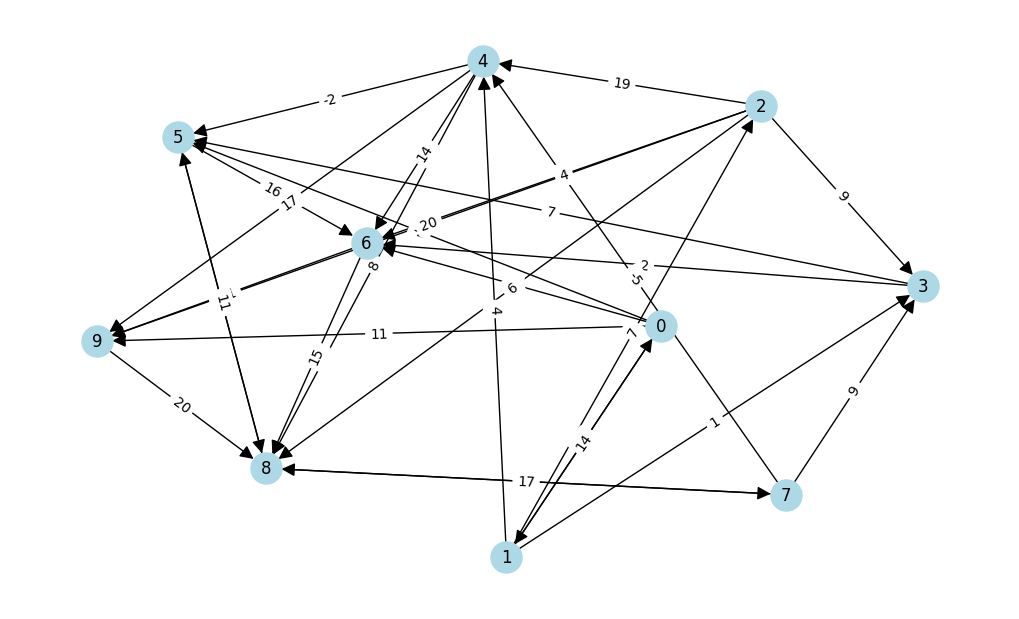

In [ ]:
def floyd_warshall(graph: nx.Graph) -> dict:
    """
    Implement the Floyd-Warshall algorithm to find the shortest paths between all pairs of nodes.
    
    Args:
        graph (nx.Graph): A graph with weighted edges.
    
    Returns:
        tuple[dict[int, int], dict[int, int]]: A tuple containing two dictionaries:
            - The first dictionary contains the predecessors for each node in the path.
            - The second dictionary contains the distances from the source node to each node.
    """
    dist = {node: {node: float('inf') for node in graph.nodes} for node in graph.nodes}
    pred = {node: {node: None for node in graph.nodes} for node in graph.nodes}

    for u, v in graph.edges:
        weight = graph[u][v]['weight']
        dist[u][v] = weight
        pred[u][v] = u

    for node in graph.nodes:
        dist[node][node] = 0

    for k in graph.nodes:
        for i in graph.nodes:
            for j in graph.nodes:
                if dist[i][k] + dist[k][j] < dist[i][j]:
                    dist[i][j] = dist[i][k] + dist[k][j]
                    pred[i][j] = pred[k][j]

    for node in graph.nodes:
        if dist[node][node] < 0:
            raise ValueError("Graph contains a negative-weight cycle")

    return pred, dist

In [ ]:
try:
    pred, dist = nx.floyd_warshall(graph)
    for k, v in dist.items():
        print(f"Distances with {k} source:", dict(v))
except ValueError:
    print("Negative cycle detected")

Negative cycle detected


---

In [24]:
def calculate_time(func, num_of_nodes, completeness, directed=False, draw=False):
    """
    Function to calculate the time taken by the given function.
    :param callable func: function (either Floyd-Warshall's or Bellman-Ford's algorithm)
    :param int size: size of matrix
    :return float: time of code runnin
    """
    graph = gnp_random_connected_graph(num_of_nodes, completeness, directed, draw)


    if func == floyd_warshall:
        graph = nx.to_numpy_array(graph, weight='weight').tolist()

    start_time = time.time()
    

    if func == floyd_warshall:
        func(graph)
    else:
        func(graph, 0)

    return time.time() - start_time

sizes = [10, 50, 100, 200, 500]
completeness = 0.5
directed = True

floyd_warshall_data = []
bellman_ford_data = []


for size in sizes:
    floyd_warshall_time = calculate_time(floyd_warshall, size, completeness, directed)
    bellman_ford_time = calculate_time(bellman_ford, size, completeness, directed)

    floyd_warshall_data.append(floyd_warshall_time)
    bellman_ford_data.append(bellman_ford_time)


plt.figure(figsize=(10, 5))
plt.plot(sizes, floyd_warshall_data, label="Floyd-Warshall", color="red", marker='o')
plt.plot(sizes, bellman_ford_data, label="Bellman-Ford", color="blue", marker='o')

plt.title("Floyd-Warshall's vs Bellman-Ford's Algorithm Time Comparison")
plt.xlabel("Number of Nodes")
plt.ylabel("Time (seconds)")
plt.legend()
plt.show()



ValueError: Graph contains a negative-weight cycle

## Some useful explanations
### How to get list of edges for your algorithm

In [ ]:
edges = list(G.edges()) # by default G.edges are EdgesView class

In [ ]:
edges[:5]

### To get edges with weights

In [ ]:
edges = list(G.edges(data=True))

In [ ]:
edges[:5]

In [ ]:
nodes = list(G.nodes())
print(nodes)

## Example on time measuring

Read more on this: https://realpython.com/python-timer/

Recall that you should measure times for 5, 10, 20, 50, 100, 200, 500 nodes 1000 times (and take mean of time taken for each node amount).

Then you should build the plot for two algorithms (x - data size, y - mean time of execution).

In [ ]:
import time
from tqdm import tqdm

In [ ]:
NUM_OF_ITERATIONS = 1000
time_taken = 0
for i in tqdm(range(NUM_OF_ITERATIONS)):
    
    # note that we should not measure time of graph creation
    G = gnp_random_connected_graph(100, 0.4, False)
    
    start = time.time()
    tree.minimum_spanning_tree(G, algorithm="prim")
    end = time.time()
    
    time_taken += end - start

time_taken / NUM_OF_ITERATIONS

## Task 2. Decision Tree Classifier 

In [ ]:
# scikit-learn package
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.model_selection import train_test_split

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### General idea

#### You are expected to write a quite simple, yet good core logic of decision tree classifier class. Additionaly, you need to test your results and write down a report on what you've done, which principles used and explain the general process.

#### Hopefully, you have already learned what is decision tree classifier and how it work. For better understanding, and in case if something is still unclear for you, here are some useful links on basics of DTC:
- https://www.youtube.com/watch?v=ZVR2Way4nwQ
- https://towardsdatascience.com/decision-tree-classifier-explained-a-visual-guide-with-code-examples-for-beginners-7c863f06a71e
- https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
- https://www.kaggle.com/code/prashant111/decision-tree-classifier-tutorial
- https://towardsdatascience.com/decision-tree-classifier-explained-in-real-life-picking-a-vacation-destination-6226b2b6057

#### Also, for those interested to learn more about machine learning and particulary Desicion Trees - here is a great course on Coursera (you may be interested in the whole course or just this particular week):
- https://www.coursera.org/learn/advanced-learning-algorithms/home/week/4


![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


### Dataset
#### You can use Iris dataset for this task. It is a very popular dataset for machine learning and data science. It contains 150 samples of 3 different species of Iris flowers (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimeters. 
Read more on this: https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html
https://en.wikipedia.org/wiki/Iris_flower_data_set
#### However, using more interesting and intricate datasets is much appreciated. You can use any dataset you want, but it should be a classification one. For example you can use breast cancer or wine datasets, which are also available in sklearn.datasets. Or you can use any other dataset you find interesting.
P.S. In case you are not sure if your dataset is suitable, feel free to ask assistants :).

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

In [ ]:
# Load dataset
iris = load_iris()
dir(iris)

In [ ]:
iris.data.shape

This means that we have 150 entries (samples, infos about a flower). The columns being: Sepal Length, Sepal Width, Petal Length and Petal Width(features). Let's look at first two entries:

In [ ]:
iris.data[0:2]

### To undestand data little bit better, let's plot some features

In [ ]:
X = iris.data[:, :2]  # we only take the first two features.
y = iris.target

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("Sepal length")
plt.ylabel("Sepal width")

From this we can clearly see, that even basing on those two parameters, we can clearly divide (classify) out data into several groups. For this, we will use decision tree classifier: https://scikit-learn.org/stable/modules/tree.html#tree

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Example of usage


**Decision Trees (DTs) are a non-parametric supervised learning method used for classification and regression**. The goal is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. A tree can be seen as a piecewise constant approximation.

In [ ]:
clf = DecisionTreeClassifier()

X, y = iris.data, iris.target
X.shape, y.shape

### Train / test split

We train our model using training dataset and evaluate its performance basing on the test dataset. Reason to use two separate datasets is that our model learns its parameters from data, thus test set allows us to check its possibilities on completely new data.

In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size= 0.20)
X_test.shape, y_test.shape

### Model learning

It learns its parameters (where it should split data and for what threshold value) basing on the training dataset. It is done by minimizing some cost function (e.g. Gini impurity or entropy).

In [ ]:
clf = clf.fit(X, y)

### Visualization of produced tree

You do not need to understand this piece of code :)

In [ ]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("iris")

In [ ]:
dot_data = tree.export_graphviz(clf, out_file=None, 
                     feature_names=iris.feature_names,  
                     class_names=iris.target_names,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Prediction step

Now we can use our model to predict which type has a flower, basing on its parameters.

This is conducted basically via traversing the tree that you can see above.

In [ ]:
predictions = clf.predict(X_test)

### We can also measure the accuracy of our model

In [ ]:
sum(predictions == y_test) / len(y_test)

To get clearer intuition about predicion, let's look at those X, that should be labeled to some flower

In [ ]:
y_test


Here you can traverse the tree above by yourself and make sure that prediction works

In [ ]:
X_test[1]

In [ ]:
clf.predict([X_test[1]])

![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)

### Finally, it is your turn to write such classifier by yourself!

####  Gini impurity

Decision trees use the concept of Gini impurity to describe how “pure” a node is. A node is pure (G = 0) if all its samples belong to the same class, while a node with many samples from many different classes will have a Gini closer to 1.

$G = 1 - \sum_{k=1}^{n}p_{k}^2$

For example, if a node contains five samples, with two belonging to the first class (first flower), two of class 2, one of class 3 and none of class 4, then

$G = 1 - (\frac{2}{5})^2 - (\frac{2}{5})^2 - (\frac{1}{5})^2 = 0.64$

#### Remarks 
- We recommend using additional functions in `DecisionTreeClassifier` class, to make the implementation process easier.
- [use this hint](https://arc.net/l/quote/pqvyjqei)

In [ ]:

class Node:
    def __init__(self, X: npt.NDArray, y: npt.NDArray):
        """
        :param X: numpy array of form [[feature1,feature2, ... featureN], ...] (i.e. [[1.5, 5.4, 3.2, 9.8] , ...] for case with iris d.s.)
        :param y: numpy array of from [class1, class2, ...] (i.e. [0,1,1,2,1,0,...] for case with iris d.s.)
        """

        self.X = X
        self.y = y
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth: int) -> None:
        self.max_depth = max_depth
        self.tree = None
        self.number_of_classes = None
        
        
    def fit(self, X: npt.NDArray, y: npt.NDArray) -> None:
        """
        Basically, function that performs all the training (building of a tree)
        We recommend to use it as a wrapper of recursive building function
        """
        self.number_of_classes = np.unique(y).size


    
    def predict(self, X_test: npt.NDArray) -> list:
        """
        Traverse the tree while there is a child
        and return the predicted class for it 
        """
        pass

In [ ]:

def evaluate(X_test: list[list], y_test: list) -> float:
    """
    Returns accuracy of the model (ratio of right guesses to the number of samples)
    """
    pass

***put your code below, with usage and evaluation of Decision classifier tree*** (delete this)

In [ ]:
ЛАПЛАС - Ймовірність
list